# Demonstrate Use

- get_initial_plan()
- instantiate the recalculator object
- calculate how many minutes of charge are still needed
- after interval passes, get new plan with updated info
- repeat
- return combined schedule


In [1]:
import os
os.chdir("/Users/jen/watttime-python-client")

import watttime.api as wt
from datetime import timedelta, datetime
from pytz import UTC
import pandas as pd

from watttime.api import WattTimeOptimizer,WattTimeRecalculator,WattTimeForecast
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def get_forecast_dataframe(
          start_time: datetime = datetime(2025, 1, 1, hour=21, second=1, tzinfo=UTC),
          end_time: datetime = datetime(2025, 1, 2, hour=8, second=1, tzinfo=UTC),
          horizon_hours: int = 12,
          region: str = 'CAISO_NORTH'
        ) -> pd.DataFrame:
        try:
            username = os.getenv("WATTTIME_USER")
            password = os.getenv("WATTTIME_PASSWORD")
            
            if not username or not password:
                raise ValueError("WattTime credentials not found in environment variables")
                
            wth = wt.WattTimeForecast(username=username, password=password)
            
            forecast_dataframe = wth.get_historical_forecast_pandas(
                start=start_time + timedelta(minutes=5),
                end=end_time,
                region=region,
                signal_type="co2_moer",
                horizon_hours=horizon_hours
            )
        except Exception as e:
            raise RuntimeError(f"Error retrieving forecast data: {str(e)}")
        
        return forecast_dataframe

In [3]:
start_time = datetime(2025, 1, 1, hour=21, second=0, tzinfo=UTC)
end_time = datetime(2025, 1, 2, hour=8, second=0, tzinfo=UTC)
region = 'CAISO_NORTH'

moers = get_forecast_dataframe(start_time=start_time, end_time=end_time, region=region)

requery_dates_ten = moers.generated_at.unique()[0::2] #10 minute intervals
requery_dates_twenty = moers.generated_at.unique()[0::4] #20 minute intervals
requery_dates_thirty = moers.generated_at.unique()[0::6] #30 minute intervals


def make_moer_list(requery_dates):
    moers_list = []
    for d in requery_dates:
        temp = moers[moers.generated_at == d]
        moers_list.append(temp)
    return moers_list


In [4]:
fitted_recalculator_ten = wt.RequerySimulator(
                                    make_moer_list(requery_dates_ten),
                                    requery_dates_ten,
                                    region = "CAISO_NORTH",
                                    window_start = start_time,
                                    window_end = end_time,
                                    usage_time_required_minutes = 240,
                                    usage_power_kw = 2
                                    ).simulate()


fitted_recalculator_twenty = wt.RequerySimulator(
                                    make_moer_list(requery_dates_twenty),
                                    requery_dates_twenty,
                                    region = "CAISO_NORTH",
                                    window_start = start_time,
                                    window_end = end_time,
                                    usage_time_required_minutes = 240,
                                    usage_power_kw = 2
                                    ).simulate()

fitted_recalculator_thirty = wt.RequerySimulator(
                                    make_moer_list(requery_dates_thirty),
                                    requery_dates_thirty,
                                    region = "CAISO_NORTH",
                                    window_start = start_time,
                                    window_end = end_time,
                                    usage_time_required_minutes = 240,
                                    usage_power_kw = 2
                                    ).simulate()

None
== Simple fit! ==
1
None
== Simple fit! ==
2
None
== Simple fit! ==
3
None
== Simple fit! ==
4
None
== Simple fit! ==
5
None
== Simple fit! ==
6
None
== Simple fit! ==
7
None
== Simple fit! ==
8
None
== Simple fit! ==
9
None
== Simple fit! ==
10
None
== Simple fit! ==
11
None
== Simple fit! ==
12
None
== Simple fit! ==
13
None
== Simple fit! ==
14
None
== Simple fit! ==
15
None
== Simple fit! ==
16
None
== Simple fit! ==
17
None
== Simple fit! ==
18
None
== Simple fit! ==
19
None
== Simple fit! ==
20
None
== Simple fit! ==
21
None
== Simple fit! ==
22
None
== Simple fit! ==
23
None
== Simple fit! ==
24
None
== Simple fit! ==
25
None
== Simple fit! ==
26
None
== Simple fit! ==
27
None
== Simple fit! ==
28
None
== Simple fit! ==
29
None
== Simple fit! ==
30
None
== Simple fit! ==
31
None
== Simple fit! ==
32
None
== Simple fit! ==
33
None
== Simple fit! ==
34
None
== Simple fit! ==
35
None
== Simple fit! ==
36
None
== Simple fit! ==
37
None
== Simple fit! ==
38
None
== Simple fit! =

<Axes: xlabel='point_time'>

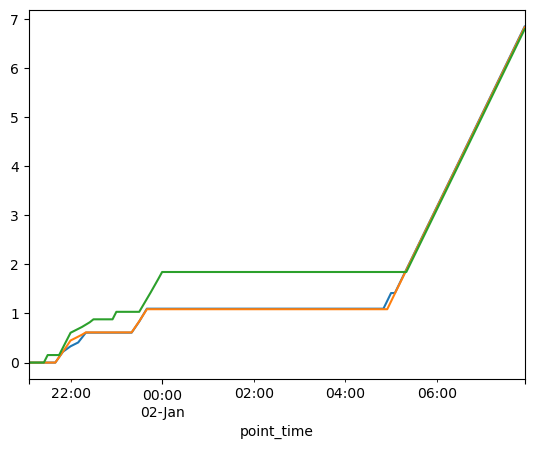

In [7]:
fitted_recalculator_ten.get_combined_schedule()["emissions_co2e_lb"].cumsum().plot(kind='line')
fitted_recalculator_twenty.get_combined_schedule()["emissions_co2e_lb"].cumsum().plot(kind='line')
fitted_recalculator_thirty.get_combined_schedule()["emissions_co2e_lb"].cumsum().plot(kind='line')

<Axes: xlabel='point_time'>

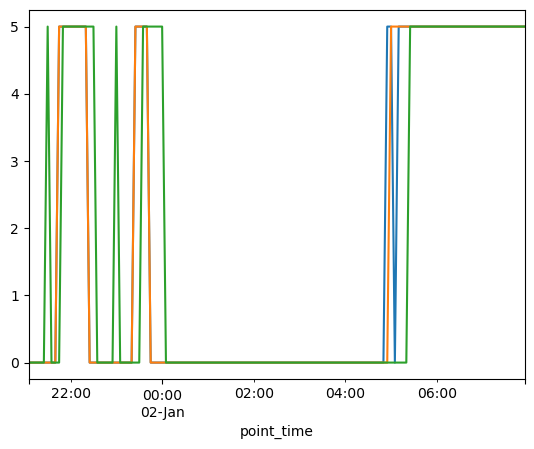

In [8]:
fitted_recalculator_ten.get_combined_schedule()["usage"].plot(kind='line')
fitted_recalculator_twenty.get_combined_schedule()["usage"].plot(kind='line')
fitted_recalculator_thirty.get_combined_schedule()["usage"].plot(kind='line')

In [2]:
username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")
region = "CAISO_NORTH"
wt_opt = WattTimeOptimizer(username,password)
wt_hist = WattTimeForecast(username=username, password=password)
start_time = datetime(2025, 1, 1, hour=21, second=0, tzinfo=UTC)
end_time = datetime(2025, 1, 2, hour=8, second=0, tzinfo=UTC)
usage_time_required_minutes = 120
charge_per_interval=None
interval = 60
usage_power_kw=5

In [ ]:
def moer_data_override(start_time,end_time,region):
    df = wt_hist.get_historical_forecast_pandas(start=start_time,end=end_time,region=region)
    return df[df.generated_at == df.generated_at.min()]

def __initial_plan():
    # set up
    initial_usage_plan = wt_opt.get_optimal_usage_plan(
        region = region,
        usage_window_start=start_time,
        usage_window_end=end_time,
        usage_time_required_minutes=usage_time_required_minutes,
        usage_power_kw=usage_power_kw,
        charge_per_interval=None,
        optimization_method="simple",
        moer_data_override = moer_data_override(start_time,end_time,region)
    )
    return initial_usage_plan

def next_query_time(time,interval):
    return time + timedelta(minutes=interval)

initial_usage_plan = __initial_plan()

None
== Simple fit! ==


In [22]:
recalculator = WattTimeRecalculator(
    initial_schedule = initial_usage_plan,
    start_time=start_time,
    end_time=end_time,
    total_time_required=usage_time_required_minutes,
    charge_per_interval=charge_per_interval
)

<Axes: xlabel='point_time'>

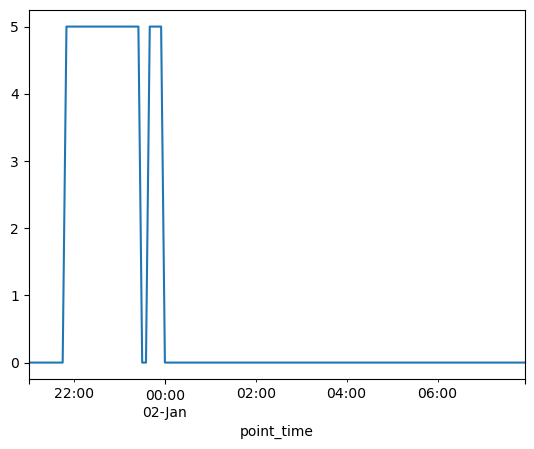

In [23]:
initial_usage_plan["usage"].plot(kind="line")

In [24]:
new_query_time = next_query_time(start_time,interval=interval)

recalculator.update_charging_schedule(
            next_query_time=start_time
        )

recalculator.get_remaining_time_required(new_query_time)
first_combined_schedule = recalculator.get_combined_schedule()

In [25]:
recalculator.get_remaining_time_required(new_query_time)

105

In [21]:
new_usage_plan = wt_opt.get_optimal_usage_plan(
    region = region,
    usage_window_start=new_query_time,
    usage_window_end=end_time,
    usage_time_required_minutes=110,
    usage_power_kw=usage_power_kw,
    charge_per_interval=None,
    optimization_method="simple",
    moer_data_override=moer_data_override(new_query_time,end_time,region)
)

None
== Simple fit! ==


In [9]:
new_usage_plan["usage"].sum()

105.0

In [10]:
initial_usage_plan["usage"].sum()

120.0

## Contiguity Test

In [39]:
def fitted_contiguous_recalculator(region, interval):
    username = os.getenv("WATTTIME_USER")
    password = os.getenv("WATTTIME_PASSWORD")
    region = region
    wt_opt = WattTimeOptimizer(username,password)
    wt_hist = WattTimeForecast(username=username, password=password)
    start_time = datetime(2025, 1, 1, hour=21, second=0, tzinfo=UTC)
    end_time = datetime(2025, 1, 2, hour=8, second=0, tzinfo=UTC)
    usage_time_required_minutes = 120
    charge_per_interval=[usage_time_required_minutes]
    interval = interval
    usage_power_kw=5

    def moer_data_override(start_time,end_time,region):
        df = wt_hist.get_historical_forecast_pandas(start=start_time,end=end_time,region=region)
        return df[df.generated_at == df.generated_at.min()]

    def __initial_plan():
        # set up
        initial_usage_plan = wt_opt.get_optimal_usage_plan(
            region = region,
            usage_window_start=start_time,
            usage_window_end=end_time,
            usage_time_required_minutes=usage_time_required_minutes,
            usage_power_kw=usage_power_kw,
            charge_per_interval=charge_per_interval,
            optimization_method="auto",
            moer_data_override = moer_data_override(start_time,end_time,region)
        )
        return initial_usage_plan

    def next_query_time(time,interval):
        return time + timedelta(minutes=interval)

    initial_usage_plan = __initial_plan()

    recalculator = WattTimeRecalculator(
        initial_schedule = initial_usage_plan,
        start_time=start_time,
        end_time=end_time,
        total_time_required=usage_time_required_minutes,
        charge_per_interval=charge_per_interval
    )

    recalculator.update_charging_schedule(
            next_query_time=start_time, 
            next_new_schedule_start_time=next_query_time(start_time,interval)
        )

    optimization_outcomes = recalculator.contiguity_values_dict
    start_time = next_query_time(start_time,interval)

    # automation minion
    while optimization_outcomes["remaining_time_required"] > 0:
        new_usage_plan = wt_opt.get_optimal_usage_plan(
            region = region,
            usage_window_start=start_time,
            usage_window_end=end_time,
            usage_time_required_minutes=optimization_outcomes["remaining_time_required"],
            usage_power_kw=usage_power_kw,
            charge_per_interval=[optimization_outcomes["remaining_time_required"]],
            optimization_method="auto",
            moer_data_override=moer_data_override(start_time,end_time,region)
        )

        recalculator.update_charging_schedule(
            new_schedule = new_usage_plan, 
            next_query_time=start_time,
            next_new_schedule_start_time = next_query_time(start_time,interval)
        )

        optimization_outcomes = recalculator.contiguity_values_dict
        print(optimization_outcomes)
        print(recalculator.sleep_delay)

        if recalculator.sleep_delay is True:
            delta = optimization_outcomes["delay_in_minutes"]
            start_time = next_query_time(start_time,delta)
        else:
            start_time = next_query_time(start_time,interval)
        
    return recalculator   

In [40]:
recalculator_onetwenty_CAISO = fitted_contiguous_recalculator('CAISO_NORTH',120)

[24]
== Fixed contiguous fit! ==


In [44]:
recalculator_sixty_CAISO = fitted_contiguous_recalculator('CAISO_NORTH',60)

In [42]:
recalculator_fifteen_CAISO = fitted_contiguous_recalculator('CAISO_NORTH',15)

[24]
== Fixed contiguous fit! ==
[24]
== Fixed contiguous fit! ==
{'delay_usage_window_start': None, 'delay_in_minutes': None, 'delay_in_intervals': None, 'remaining_time_required': 120, 'num_segments_complete': 0}
False
[24]
== Fixed contiguous fit! ==
{'delay_usage_window_start': None, 'delay_in_minutes': None, 'delay_in_intervals': None, 'remaining_time_required': 120, 'num_segments_complete': 0}
False
[24]
== Fixed contiguous fit! ==
{'delay_usage_window_start': Timestamp('2025-01-01 23:45:00+0000', tz='UTC'), 'delay_in_minutes': 105, 'delay_in_intervals': 21, 'remaining_time_required': 0, 'num_segments_complete': 1}
True


<Axes: xlabel='point_time'>

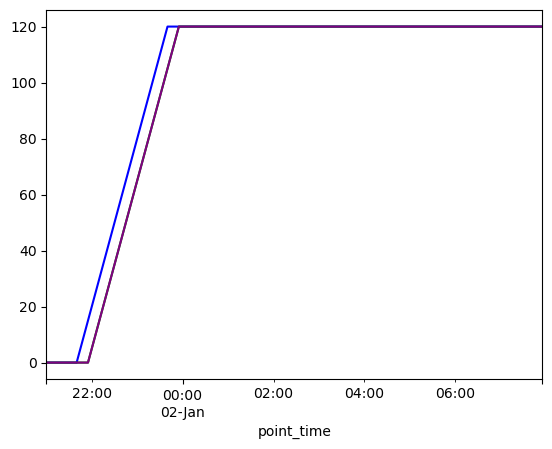

In [48]:
recalculator_fifteen_CAISO.get_combined_schedule()["usage"].cumsum().plot(kind='line',color="blue")
recalculator_sixty_CAISO.get_combined_schedule()["usage"].cumsum().plot(kind='line',color="green")
recalculator_onetwenty_CAISO.get_combined_schedule()["usage"].cumsum().plot(kind='line', color="purple")

<Axes: xlabel='point_time'>

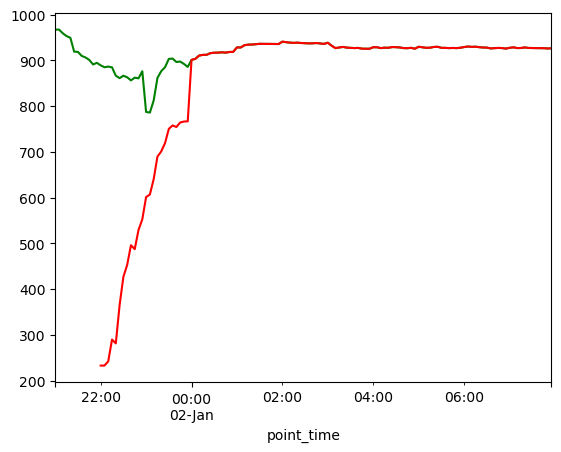

In [49]:
recalculator_sixty_CAISO.all_schedules[0][0]["pred_moer"].plot(kind='line',color='green')
recalculator_sixty_CAISO.all_schedules[1][0]["pred_moer"].plot(kind='line',color='red')

<Axes: xlabel='point_time'>

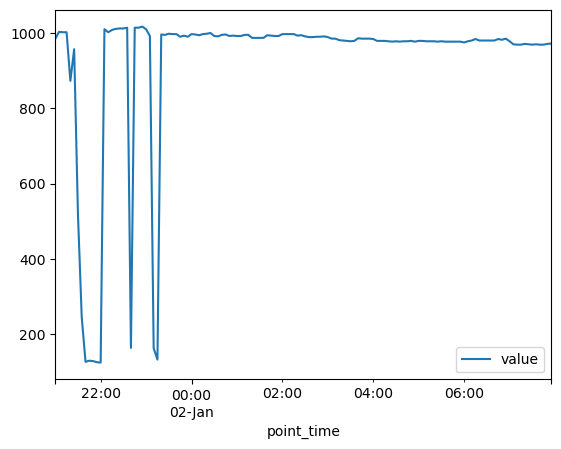

In [51]:
wt_actuals.get_historical_pandas(start=recalculator_fifteen_CAISO.get_combined_schedule().index.min(), end=recalculator_fifteen_CAISO.get_combined_schedule().index.max(),region="CAISO_NORTH").set_index('point_time').plot(kind='line')

<Axes: xlabel='point_time'>

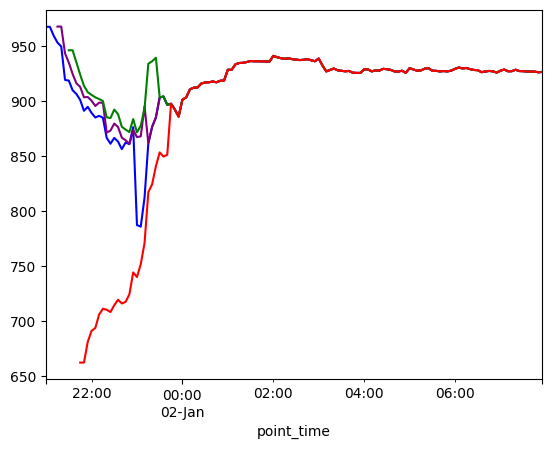

In [137]:
recalculator_fifteen_CAISO.all_schedules[0][0]["pred_moer"].plot(kind='line',color='blue')
recalculator_fifteen_CAISO.all_schedules[1][0]["pred_moer"].plot(kind='line',color='purple')
recalculator_fifteen_CAISO.all_schedules[2][0]["pred_moer"].plot(kind='line',color='green')
recalculator_fifteen_CAISO.all_schedules[3][0]["pred_moer"].plot(kind='line',color='red')

<Axes: xlabel='point_time'>

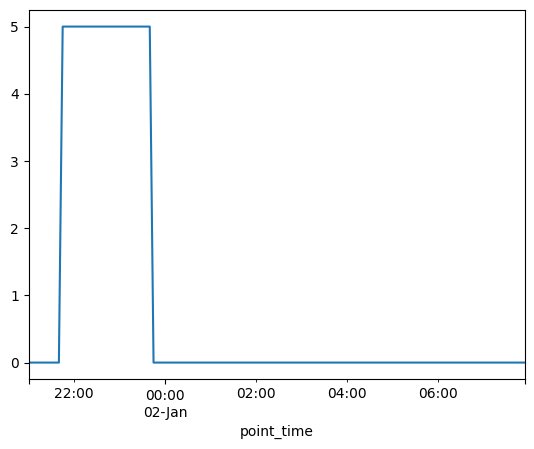

In [136]:
recalculator_fifteen_CAISO.get_combined_schedule()["usage"].plot(kind='line')